In [1]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.special import softmax

# Problem 1

In [2]:
hw5p1 = pickle.load(open('hw5p1.pkl', 'rb'))
hw5p1

{'data': array([[0.72727273, 0.56565657, 1.        ],
        [0.46464646, 0.33333333, 1.        ],
        [0.67676768, 0.58585859, 1.        ],
        ...,
        [0.38383838, 0.25252525, 1.        ],
        [0.77777778, 0.48484848, 1.        ],
        [0.08080808, 0.8989899 , 1.        ]]),
 'labels': array([2, 1, 1, ..., 2, 2, 0]),
 'testdata': array([[0.98989899, 0.7979798 , 1.        ],
        [0.84848485, 0.35353535, 1.        ],
        [0.95959596, 0.42424242, 1.        ],
        ...,
        [0.48484848, 0.58585859, 1.        ],
        [0.39393939, 0.24242424, 1.        ],
        [0.88888889, 0.71717172, 1.        ]]),
 'testlabels': array([2, 1, 1, ..., 1, 1, 2])}

In [3]:
# make copies of data so that we don't mess them up
data = np.array(hw5p1['data'])
labels = np.array(hw5p1['labels'])
testdata = np.array(hw5p1['testdata'])
testlabels = np.array(hw5p1['testlabels'])

In [4]:
n = len(data)
T = 10000

In [5]:
def encode(y):
    unique_values = np.unique(y)
    num_unique = len(unique_values)
    encoded = []

    for value in y:
        encoding = np.zeros(num_unique)
        index = np.where(unique_values == value)[0][0]
        encoding[index] = 1
        encoded.append(encoding)

    return np.array(encoded)

In [6]:
def logreg_nll_gd(train_x, train_y, eta=2/n, num_steps=T):
    error_rates = []
    nlls = []
    ts = []

    encoded_y = encode(train_y)
    W = np.zeros((train_x.shape[1], encoded_y.shape[1]))

    for t in range(num_steps):
        W += eta * train_x.T @ (encoded_y - softmax(train_x @ W, axis=1))

        # part b: report nlls and error rates
        if (t+1) % 20 == 0:
            ts.append(t+1)
            pred_probs = softmax(train_x @ W, axis=1)
            pred_y = np.argmax(pred_probs, axis=1)

            # calculate negative log likelihood
            class_probs = pred_probs[np.arange(len(train_y)), train_y]
            nll = -np.sum(np.log(class_probs))
            nlls.append(nll)

            # calculate error rate
            error_rate = 1 - np.mean(pred_y == train_y)
            error_rates.append(error_rate)

    return (W, nlls, error_rates, ts)

In [7]:
def get_test_err(test_x, test_y, W):
    test_pred = softmax(test_x @ W, axis=1)
    test_pred_y = np.argmax(test_pred, axis=1)
    test_err = 1 - np.mean(test_pred_y == test_y)
    return test_err

In [8]:
W, nlls, error_rates, ts = logreg_nll_gd(data, labels)

In [9]:
get_test_err(testdata, testlabels, W)

0.20925000000000005

In [10]:
W

array([[-15.56255001,   7.98591001,   7.57664   ],
       [  6.386991  ,  -5.62208406,  -0.76490694],
       [  3.53435652,  -0.96013681,  -2.57421971]])

In [11]:
error_rates[-1] # training error rate

0.2025

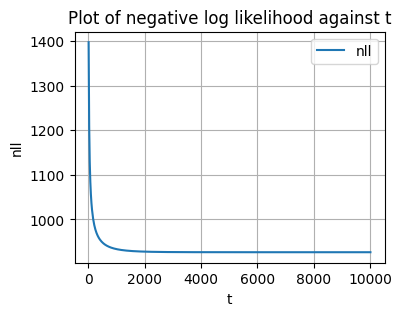

In [12]:
plt.figure(figsize=(4, 3))
plt.plot(ts, nlls, label='nll')
plt.xlabel('t')
plt.ylabel('nll')
plt.title('Plot of negative log likelihood against t')
plt.legend()
plt.grid(True)
plt.show()

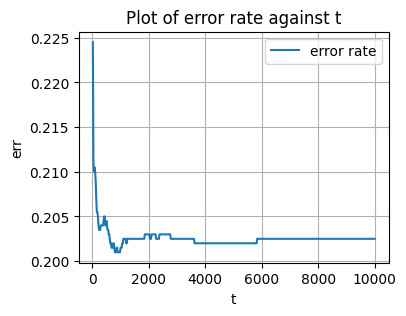

In [13]:
plt.figure(figsize=(4, 3))
plt.plot(ts, error_rates, label='error rate')
plt.xlabel('t')
plt.ylabel('err')
plt.title('Plot of error rate against t')
plt.legend()
plt.grid(True)
plt.show()

# Problem 5

In [14]:
def cal(X, y, W):
    v1 = X @ W
    v2 = torch.softmax(v1, dim=1)
    v3 = v2[torch.arange(len(y)), y]
    v4 = torch.log(v3)
    v5 = torch.sum(v4)
    return -v5

In [15]:
def logreg_nll_gd_ad(K, eta, T, X, y):
    X = torch.tensor(X, dtype=torch.double)
    y = torch.tensor(y, dtype=torch.int)
    W = torch.zeros(X.shape[1], K, dtype=torch.double)
    W.requires_grad = True
    for _ in range(T):
        J = cal(X, y, W)
        J.backward() 
        with torch.no_grad():
            W -= eta * W.grad
            W.grad.zero_()
    return W.detach()

In [16]:
W2 = logreg_nll_gd_ad(3, 2/n, T, data, labels)

In [17]:
W2

tensor([[-15.5626,   7.9859,   7.5766],
        [  6.3870,  -5.6221,  -0.7649],
        [  3.5344,  -0.9601,  -2.5742]], dtype=torch.float64)

In [18]:
def get_norm_diff(W1, W2):
    return np.linalg.norm(W1 - W2, 'fro')

In [19]:
get_norm_diff(W, W2.numpy())

1.4582081031998637e-13

# Problem 6

In [20]:
click = pickle.load(open('hw5click.pkl', 'rb'))

In [21]:
# make copies of data so that we don't mess them up
cdata = np.array(click['data'])
clabels = np.array(click['labels'])
ctestdata = np.array(click['testdata'])
ctestlabels = np.array(click['testlabels'])

In [22]:
wmle = np.array(click['w_mle'])
bmle = np.array(click['b_mle'])

In [23]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

In [24]:
def ci_gradient(w, b, X, y):
    predictions = logistic(X @ w + b)
    gradient_b = np.sum(predictions - y)
    gradient_w = (X.T @ (predictions - y))
    return np.append(gradient_w, gradient_b)

In [25]:
ci_gradient(wmle, bmle, cdata, clabels)

array([7.58708797e-07, 5.32074888e-07, 6.25551399e-07, 1.37638182e-06,
       3.90259085e-07, 2.61856602e-07, 1.44954518e-07, 1.22268314e-07,
       7.73513416e-08, 6.42004352e-08, 7.72985214e-08, 7.40473478e-08,
       4.75441615e-08, 5.84252984e-08, 7.05374272e-08, 7.73289826e-08,
       5.33326632e-08, 3.61837029e-08, 6.25599863e-08, 4.32678853e-08,
       4.02153408e-08, 3.88878285e-08, 6.48395355e-08, 3.59464742e-08,
       4.49839034e-08, 4.40184785e-08, 4.79648875e-08, 5.86180604e-08,
       4.41668122e-08, 2.83910068e-08, 2.48625036e-08, 1.93513862e-08,
       2.84955259e-08, 3.28347158e-08, 4.60171208e-08, 3.29880665e-08,
       2.37288118e-08, 1.93342615e-08, 2.36991692e-08, 2.19820677e-08,
       4.09004647e-08, 3.10452881e-08, 3.87866219e-08, 4.73770818e-08,
       3.89088202e-08, 1.92184566e-08, 1.92069420e-08, 3.16721254e-08,
       2.56295447e-08, 3.00256999e-08, 3.93349902e-08, 3.08200985e-08,
       3.23679314e-08, 2.72387874e-08, 5.03784868e-07])

In [26]:
# calculate gradients of J
gradient_arr = ci_gradient(wmle, bmle, cdata, clabels)
np.linalg.norm(gradient_arr)

1.935945342948108e-06

In [27]:
def ci_get_err(w, b, X, y):
    pred = (X @ w + b > 0).astype(int)
    return np.sum(pred != y)/len(y)

In [28]:
ci_train_err = ci_get_err(wmle, bmle, cdata, clabels)
ci_test_err = ci_get_err(wmle, bmle, ctestdata, ctestlabels)
print(ci_train_err, ci_test_err)

0.0453 0.054


# Problem 8

In [29]:
def bal_nll_gd(train_x, train_y, wmle, bmle, eta=0.001, num_steps=50000, lam=0.01):
    w = np.array(wmle)
    b = bmle
    # w = np.ones(train_x.shape[1])
    # b = 1

    # calculate n0 and n1
    n0 = np.sum(train_y == 0)
    n1 = np.sum(train_y == 1)

    # create encoded y
    encoded_y = np.where(train_y == 0, 0.5/n0, 0.5/n1)
            
    for t in range(num_steps):
        pred = train_x @ w + b
        shared_component = logistic(train_x @ w + b) - train_y
        
        gw = encoded_y.T * shared_component
        gb = encoded_y.T @ shared_component

        w -= eta * (lam*(w-wmle) + gw @ train_x)
        b -= eta * (lam*(b-bmle) + gb)

    return (w,b)

In [30]:
wbal, bbal = bal_nll_gd(cdata, clabels, wmle, bmle)

In [31]:
wbal, bbal

(array([ 3.18497460e-01, -5.70200630e-01,  4.16217094e-01,  6.21897467e-02,
         8.07034898e-01,  3.82515022e-01,  3.59913063e-03, -8.19004421e-02,
         5.96284167e-02,  2.26708549e-01,  2.67131184e-01, -8.99197336e-02,
        -1.45960244e-01,  1.22420712e-01,  5.16587449e-01,  1.92976402e-01,
         8.29908623e-02, -1.51292322e-01,  4.69844250e-01, -1.80470194e-01,
         1.93545638e-01, -1.37174744e-01,  2.45489374e-01, -1.94705606e-01,
         1.54401476e-01,  1.49800066e-01,  1.81407877e-01,  3.53034690e-01,
        -1.35988235e-01, -1.92745631e-01, -9.28843439e-02, -8.79546089e-01,
        -1.72931919e-02, -2.21247931e-01,  4.07982444e-03,  4.35112250e-02,
         3.42842907e-01, -6.46860498e-01,  4.58715903e-01, -2.78915770e-01,
        -2.18061843e-02, -1.25980463e-01,  2.02237764e-01,  6.86608412e-01,
         2.88289547e-01, -2.24888317e+01,  2.21785053e+01,  1.48889990e-01,
        -2.61335384e-01,  1.67277187e-01,  5.95002785e-02,  8.74198286e-03,
         2.9

In [32]:
def bal_get_err(w, b, X, y):
    predicted_labels = (X @ w + b > 0).astype(int)

    false_positive_rate = np.mean((predicted_labels == 1) & (y == 0)) / np.mean((y == 0))
    false_negative_rate = np.mean((predicted_labels == 0) & (y == 1)) / np.mean((y == 1))

    balanced_error = 0.5 * (false_positive_rate + false_negative_rate)
    return balanced_error

In [33]:
bal_train_err = bal_get_err(wbal, bbal, cdata, clabels)
bal_test_err = bal_get_err(wbal, bbal, ctestdata, ctestlabels)

In [34]:
bal_train_err, bal_test_err

(0.40113707228858, 0.3704486727742542)